In [118]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import warnings
import os
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
from analysis.risk_hypthesis_tester import RiskHypothesisTester
from utils.load_data import load_local_data

In [120]:
#suppress warning errors
warnings.filterwarnings("ignore")
#load enviroment variables
load_dotenv()

True

In [121]:
# Automatically go to project root (where .git or README.md is)
project_root = Path.cwd()
while not (project_root / "README.md").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Project root set to:", project_root)


Project root set to: /home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling


## 🧱 1. Setup & Imports

In [122]:
# Load the insurance data
processed_data_dir=os.getenv("PROCESSED_DATA")
file_path= os.path.join(processed_data_dir,'cleaned_insurance_data.csv')
df=pd.read_csv(file_path).drop('CustomValueEstimate',axis=1)
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Bank,AccountType,MaritalStatus,...,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,TotalPremium,TotalClaims,Gender_Inferred
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,512.848070,0.0,Male
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male


In [123]:
df.columns.sort_values()

Index(['AccountType', 'AlarmImmobiliser', 'Bank', 'CalculatedPremiumPerTerm',
       'CapitalOutstanding', 'Citizenship', 'Converted', 'CoverCategory',
       'CoverGroup', 'CoverType', 'CrossBorder', 'Cylinders', 'ExcessSelected',
       'Gender_Inferred', 'IsVATRegistered', 'LegalType', 'MainCrestaZone',
       'MaritalStatus', 'Model', 'NewVehicle', 'NumberOfDoors', 'PolicyID',
       'PostalCode', 'Product', 'Province', 'Rebuilt', 'RegistrationYear',
       'Section', 'SubCrestaZone', 'SumInsured', 'TermFrequency', 'Title',
       'TotalClaims', 'TotalPremium', 'TrackingDevice', 'TransactionMonth',
       'UnderwrittenCoverID', 'VehicleIntroDate', 'VehicleType', 'WrittenOff',
       'bodytype', 'cubiccapacity', 'kilowatts', 'make', 'mmcode'],
      dtype='object')

In [124]:
#rename the gender_inferred column

df=df.rename(columns={'Gender_Inferred':"Gender"})
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender'],
      dtype='object')

In [125]:

# Initialize the tester
tester = RiskHypothesisTester(df)

## A. 📍 Geographic Features

### Province, PostalCode, MainCrestaZone, SubCrestaZone

[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
[2025-06-13 15:12:00,043] INFO: Running chi-squared test for Province vs TotalClaims...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for Province vs TotalClaims...


       Chi-Squared Test: Province vs TotalClaims       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                          ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 10675.0387                     │
│ Degrees of Freedom │ 12840                          │
│ P-Value            │ 1.0000                         │
│ Conclusion         │ FAIL TO REJECT null hypothesis │
└────────────────────┴────────────────────────────────┘

[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,288] INFO: Markdown report saved to report_chi2_Province.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_Province.md
[2025-06-13 15:12:00,298] INFO: Visualizing TotalClaims by Province (bar plot)...
[2025-06-13 15:12:00,298] INFO: Visualizing TotalClaims by Province (bar plot)...
[2025-06-13 15:12:00,298] INFO: Visualizing TotalClaims by Province (bar plot)...
[2025-06-13 15:12:00,298] INFO: Visualizing TotalClaims by Province (bar plot)...
[2025-06-13 15:12:00

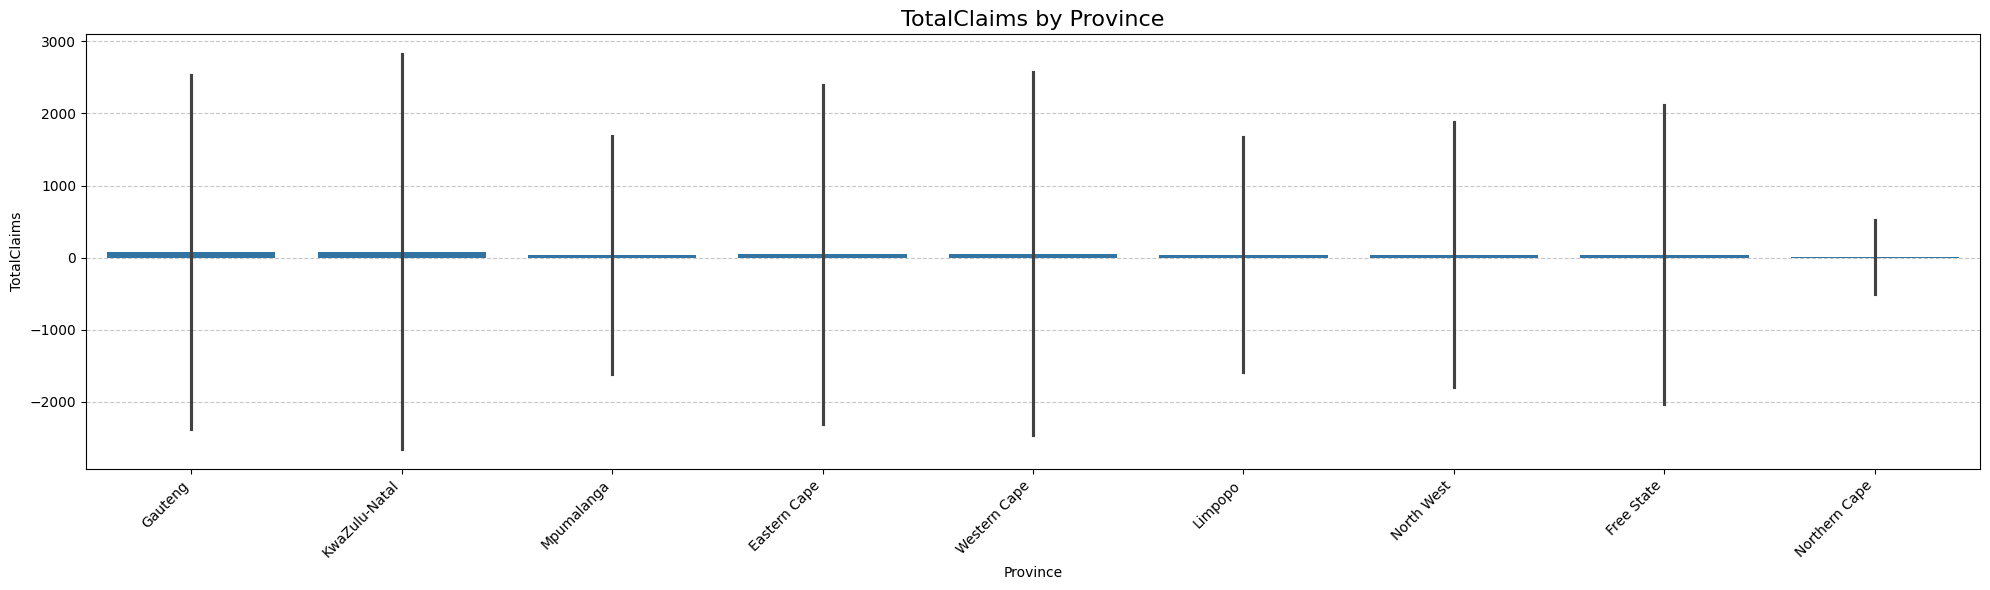

[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
[2025-06-13 15:12:02,740] INFO: Running chi-squared test for PostalCode vs TotalClaims...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for PostalCode vs TotalClaims...


      Chi-Squared Test: PostalCode vs TotalClaims      
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                          ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 1213169.1919                   │
│ Degrees of Freedom │ 1423635                        │
│ P-Value            │ 1.0000                         │
│ Conclusion         │ FAIL TO REJECT null hypothesis │
└────────────────────┴────────────────────────────────┘

[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,013] INFO: Markdown report saved to report_chi2_PostalCode.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_PostalCode.md
[2025-06-13 15:12:03,021] INFO: Visualizing TotalClaims by PostalCode (bar plot)...
[2025-06-13 15:12:03,021] INFO: Visualizing TotalClaims by PostalCode (bar plot)...
[2025-06-13 15:12:03,021] INFO: Visualizing TotalClaims by PostalCode (bar plot)...
[2025-06-13 15:12:03,021] INFO: Visualizing TotalClaims by PostalCode (bar plot)

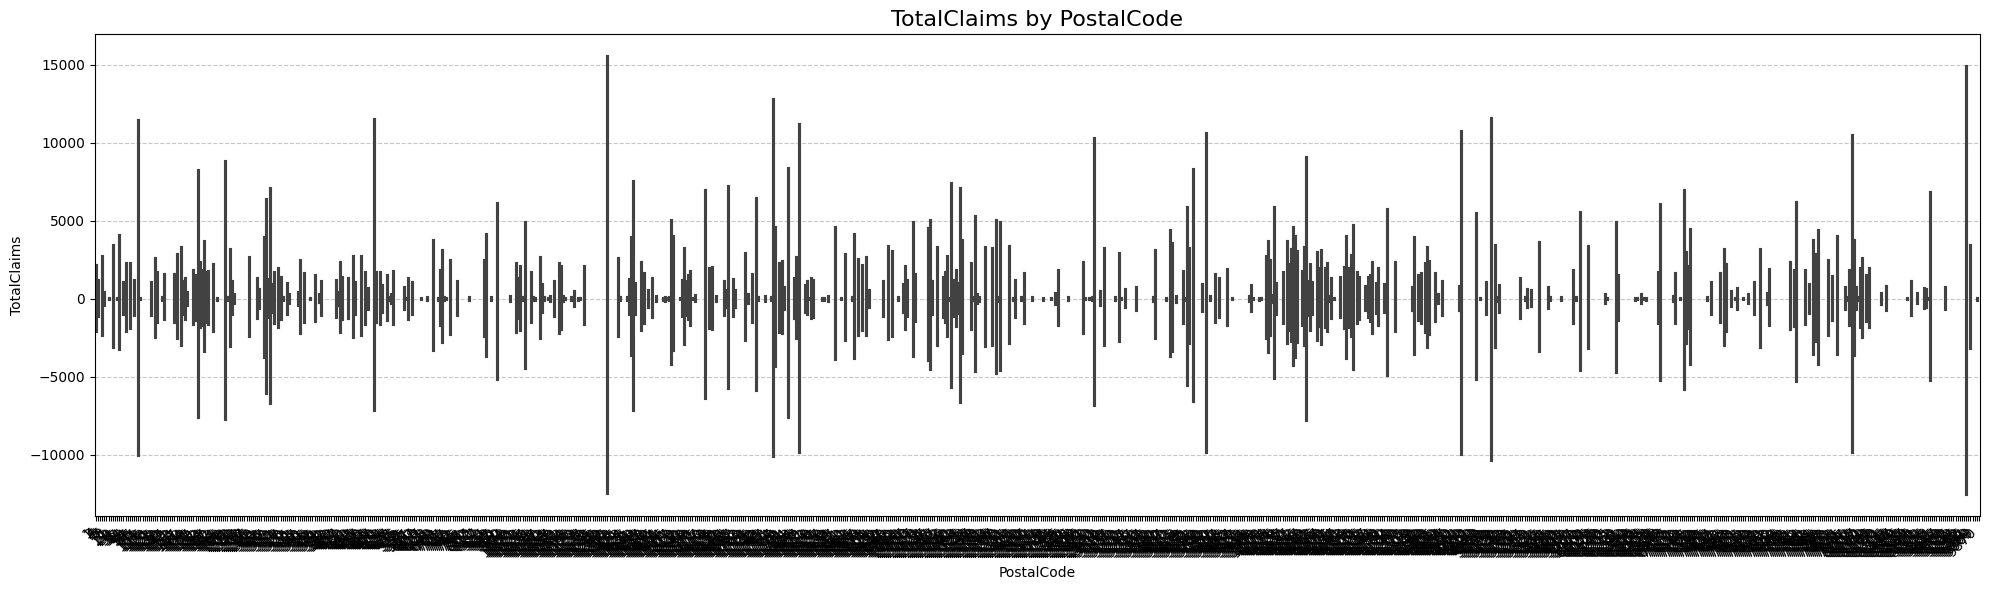

[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
[2025-06-13 15:12:13,131] INFO: Running chi-squared test for MainCrestaZone vs TotalClaims...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for MainCrestaZone vs TotalClaims...


    Chi-Squared Test: MainCrestaZone vs TotalClaims    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                          ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 21358.0602                     │
│ Degrees of Freedom │ 24075                          │
│ P-Value            │ 1.0000                         │
│ Conclusion         │ FAIL TO REJECT null hypothesis │
└────────────────────┴────────────────────────────────┘

[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,431] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 15:12:13,441] INFO: Visualizing TotalClaims by MainCrestaZone (bar plot)...
[2025-06-13 15:12:13,441] INFO: Visualizing TotalClaims by MainCrestaZone (bar plot)...
[2025-06-13 15:12:13,441] INFO: Visualizing TotalClaims by MainCrestaZone (bar plot)...
[2025-06-13 15:12:13,441] INFO: Visu

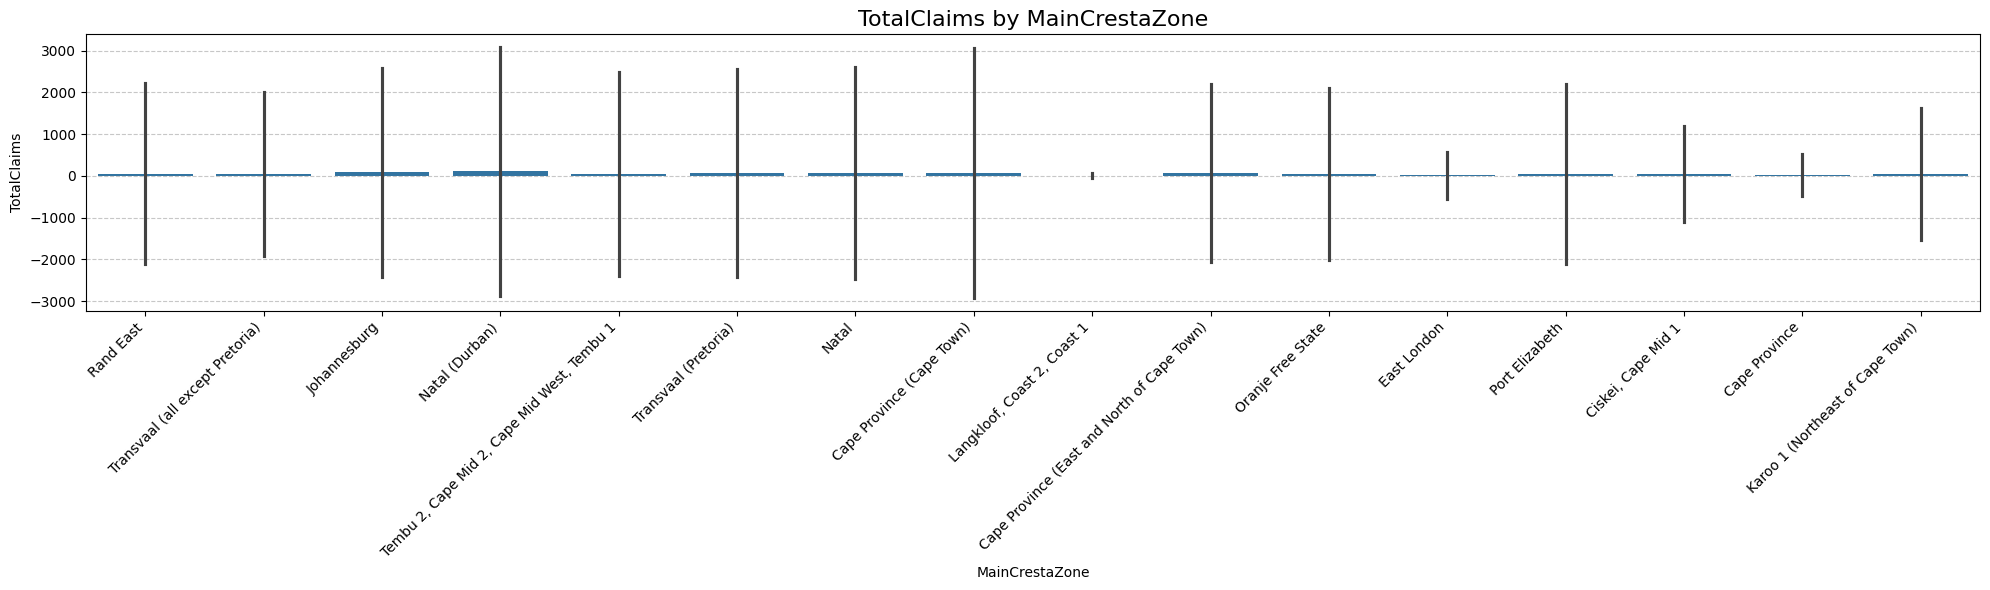

[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
[2025-06-13 15:12:16,004] INFO: Running chi-squared test for SubCrestaZone vs TotalClaims...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for SubCrestaZone vs TotalClaims...


    Chi-Squared Test: SubCrestaZone vs TotalClaims     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                          ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 56993.3657                     │
│ Degrees of Freedom │ 70620                          │
│ P-Value            │ 1.0000                         │
│ Conclusion         │ FAIL TO REJECT null hypothesis │
└────────────────────┴────────────────────────────────┘

[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,260] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 15:12:16,267] INFO: Visualizing TotalClaims by SubCrestaZone (bar plot)...
[2025-06-13 15:12:16,267] INFO: Visualizing TotalClaims by SubCrestaZone (bar plot)...
[2025-06-13 15:12:16,267] INFO: Visualizing TotalClaims by SubCrestaZone (bar plot)...
[2025-06-13 15:12:16,267] INFO: Visualizing Tot

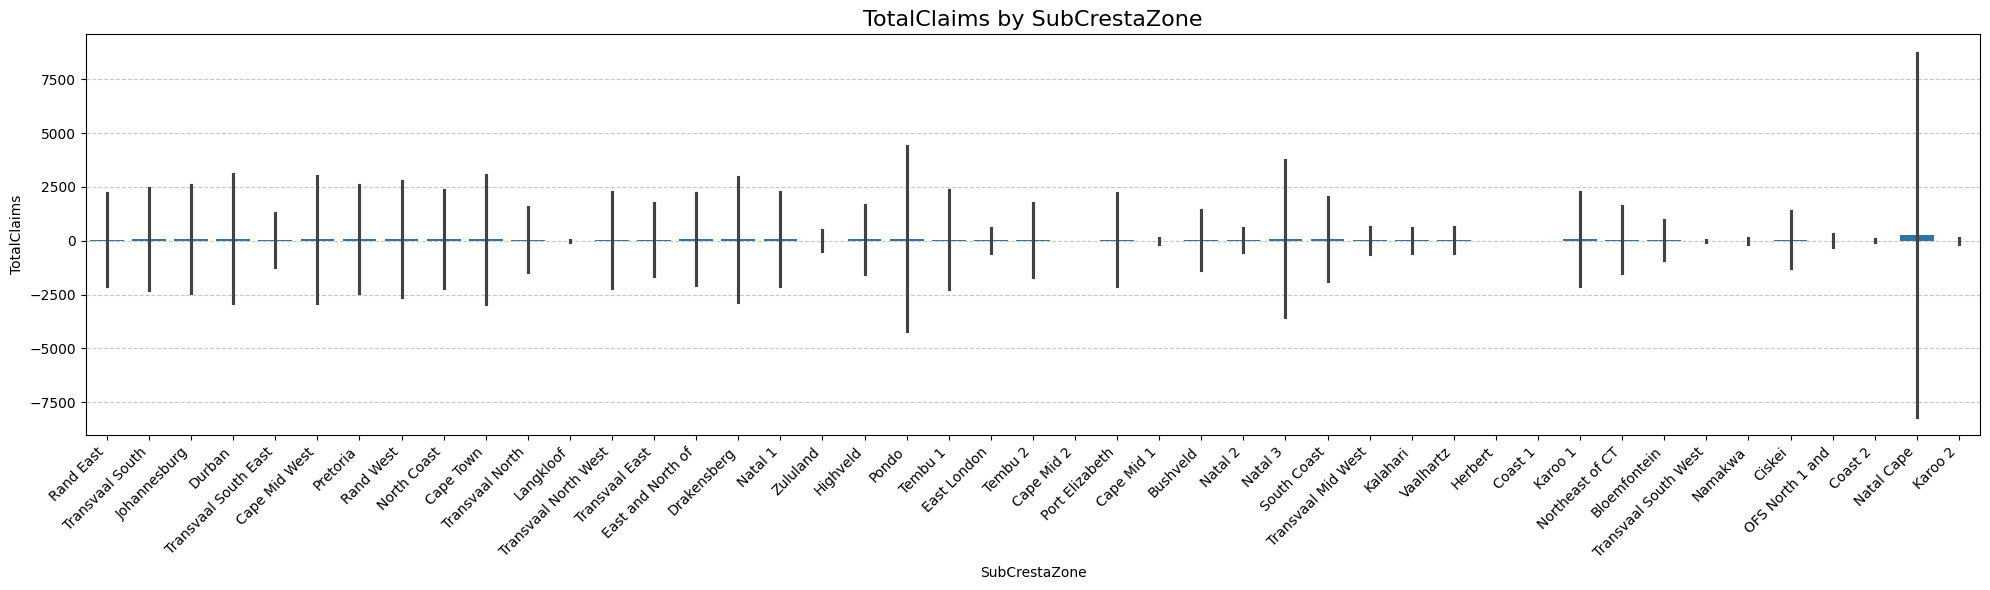

In [133]:
geo_features = ['Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone']

for feature in geo_features:
    try:
        chi2_result = tester.run_chi2(feature, binary_metric="TotalClaims")
        tester.export_markdown_report(chi2_result, f"report_chi2_{feature}.md")
        tester.visualize_metric(feature, "TotalClaims", kind="bar")
        tester.interpret_result(chi2_result)
    except Exception as e:
        print(f"Chi-squared test failed for {feature}: {e}")


## B. 👨‍👩‍👧 Demographic Features

In [127]:
# Define columns
group_col = 'Gender'
metric_col = 'TotalClaims'


In [128]:
df['Gender'].value_counts()

Gender
Male      933812
Female     65732
Name: count, dtype: int64

In [129]:
# Run the test
# result = tester.two_sample_ttest(group_col=group_col, metric_col=metric_col, equal_var=False)
result= tester.run_ttest(feature=group_col,metric=metric_col)

[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 15:07:49,438] INFO: Running t-test for TotalClaims by Gender...
INFO:analysis.risk_hypthesis_tester:Running t-test for TotalClaims by Gender...


  T-Test Result: Gender vs TotalClaims  
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric      ┃ Value                  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Group A     │ Male                   │
│ Group B     │ Female                 │
│ T-Statistic │ 2.2504                 │
│ P-Value     │ 0.0244                 │
│ Conclusion  │ REJECT null hypothesis │
└─────────────┴────────────────────────┘

In [130]:
# View result
print(result)

{'feature': 'Gender', 'metric': 'TotalClaims', 'group_a': 'Male', 'group_b': 'Female', 't_stat': 2.250445015518036, 'p_value': 0.024423519322613906, 'conclusion': 'REJECT'}


In [131]:
tester.interpret_result(result)

'We reject the null hypothesis that `Gender` has no effect on `TotalClaims` (p = 0.0244). This indicates no statistically "significant" impact of `Gender`'

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

* 'We reject the null hypothesis that `Gender` has no effect on `TotalClaims` (p = 0.0244). This suggests that `Gender` is a significant factor affecting `TotalClaims`. Consider using it in segmentation strategy or premium pricing.'
</div>

In [132]:
tester.export_markdown_report(result,'reports/hypothesis_report.md')

[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 15:07:50,422] INFO: Markdown report saved to reports/hypothesis_report.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/hypothesis_report.md
